---
# Práctica Deep Learning - Clasificación de imágenes
---

A lo largo de este trabajo abordaremos el problema de clasificar imágenes usando redes neuronales, más concretamente, redes convolucionales.

---
# Datos
---

Para la realización de este trabajo se usará el conjunto de datos [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist). Se trata de un conjunto de datos con imágenes de articulos de la tienda Zalando. Se compone de 60.000 muestras y un test de 10.000 muestras. Cada muestra es una imagen 28x28 en escala de grises asociada con una de las 10 posibles clases. Este conjunto de datos reemplaza al clásido MNIST para problemas de machine learning. 

<img src='fashion-mnist-sprite.png' width=50% />

**MNIST** es el primer conjunto de datos que los investigadores suelen usar. Se dice que "si no funciona con MNIST, no funcionará con nada" y "que funcione con MNIST no implica que funcione con otros".

Algunas de las razones por las que se quiere reemplazar al clásico MNIST:

   - MNIST es muy fácil. Las redes convoucionales alcanzan un 99.7% de presición. Técnicas clásicas de machine learning pueden llegar al 97% fácilmente. En realidad, la mayoría de los dígitos de MNIST se pueden diferenciar bastante bien solamente usando un pixel.

<img src='one_pixel.png' width=50% />
  
   - MNIST está sobreusado. En abril de 2007, investigadores de Google Brain e Ian Goodfellow sugirieron a los investigadores dejar de usar MNIST.
   - MNIST no representa a las tareas actuales de visión artificial como dijo François Chollet (creador de Keras e investigador de Google).
   
<img src='chollet.png' width=50% />


## Lectura de los datos
---

```
import tensorflow as tf
(x_train, y_train), (x_test, y_test) =  tf.keras.datasets.fashion_mnist.load_data()
```

---
# Objetivos
---

Crear una red neuronal para predecir la clase correspondiente de cada muestra.

Para ello:

* Utilizaremos disferentes estructuras de redes.
* Aplicaremos distintas técnicas de regularización.
* Data Augmentation
* Uso de técnicas de transfer learning.
   
---
# Librerías de uso
---

Para la realización del trabajo se usarán principamente las librerías de `keras`, `pandas` y `numpy`.

In [0]:
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score

from random import sample, seed
from keras.models import Sequential, Model
from keras.layers import Dense,Flatten, Activation, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, Dropout
from keras.optimizers import Adam, rmsprop
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.applications import VGG16
from keras.utils.vis_utils import plot_model
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing.image import img_to_array, array_to_img
from keras.layers.advanced_activations import LeakyReLU

import warnings
warnings.filterwarnings("ignore")

---

## Conjunto de datos Fashion MNIST
---
Se trata de un conjunto de datos con imágenes de articulos de la tienda Zalando. Se compone de 60.000 muestras y un test de 10.000 muestras. Cada muestra es una imagen 28x28 en escala de grises asociada con 10 posibles clases.

Las clases o etiquetas vienen dadas por una matriz de enteros, que van de 0 a 9. Estas, que mostraremos a continuación,  corresponden a la clase de vestimenta que representa la imagen.


| Etiqueta | Descripción |
| --- | --- |
| 0 | Camiseta/top |
| 1 | Pantalón|
| 2 |Jersey|
| 3 |Vestido|
| 4 | Chaqueta|
| 5 | Sandalia |
| 6 | Camisa |
| 7 | Zapatilla de deporte |
| 8 | Bolso |
| 9 | Botín|



In [0]:
(x_train, y_train), (x_test, y_test) =  tf.keras.datasets.fashion_mnist.load_data()

---
## Exploración de  datos
---

In [23]:
print("Número de muestras de: ")
print("- Conjunto de entrenamiento:\t{}".format(len(x_train)))
print("- Conjunto de evaluación:\t{}".format(len(x_test)))

Número de muestras de: 
- Conjunto de entrenamiento:	60000
- Conjunto de evaluación:	10000


Analizamos el primer registro de la muestra de aprendizaje. Como hemos dicho, se tratan de imágenes 28x28, luego cada imagen (registro) será una lista con 28 sublistas.

In [24]:
print("Tamaño de cada imagen: ", len(x_train[0]))

x_train.shape

Tamaño de cada imagen:  28


(60000, 28, 28)

Analizamos a continuación la variable respuesta (variable a predecir/clasificar):

Text(0.5, 1.0, 'Number of occurrences of predictive variable')

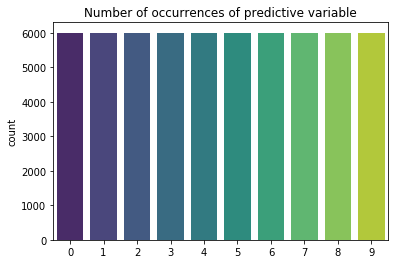

In [25]:
sns.countplot(y_train, palette="viridis").set_title('Number of occurrences of predictive variable')

Observamos que en el conjunto de entrenamiento, cada una de las clases posibles de variable respuesta tiene el mismo número de registros.

* A continuación mostraremos el **dibujo de algunas de las imágenes**:

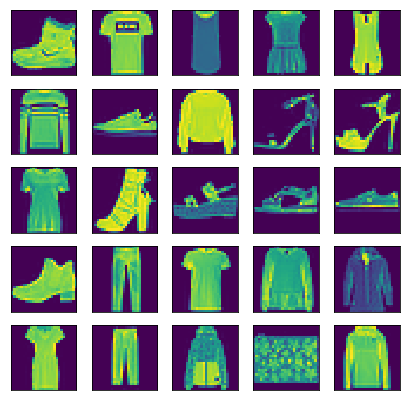

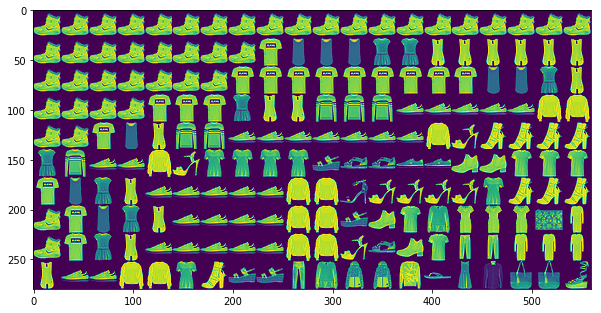

In [26]:
fig = plt.figure(figsize = (7,7))
for i in range(25):
    fig.add_subplot(5, 5, (i+1), xticks=[], yticks=[])
    plt.imshow(x_train[i])
plt.savefig('img_MNIST.jpg')

conj = np.zeros((280,560),dtype='uint8')
for i in range(10):
    idx = np.where(x_test == i)[0]
    for j in range(20):
        conj[28*i:28*(i+1),28*j:28*(j+1)] = x_train[idx[j]]

fig = plt.figure(figsize=(10,20))
imgs = plt.imshow(conj)
plt.savefig('img_MNIST_2.jpg')

---
## Preprocesamiento de los datos
---

A lo largo de este trabajo trabajaremos con dos tipos de redes neuronales: **redes neuronales artificiales** y **redes neuronales convolucionales**. Al tratarse de dos tipos de redes diferentes con propiedades y características dispares, la forma del dato de entrada (imagen) también es distinta. 

Por ejemplo, una red convolucional toma como dato de entrada un tensor de la forma `(image_height, image_width, image_channels)`. En este caso, para ajustarse a las características de las imágenes de MNIST, será (28, 28, 1),  ya que usaremos un solo canal (gris) en las imágenes. Por otro lado, las redes neuronales artificiales deben recibir como dato de entrada cada imagen de forma aplanada, i.e, como un vector de 28x28 = 784 posiciones.

Además, aprovecharemos en ambas definiciones para normalizar el contenido de estas imágenes, están en escalas de grises con valores uint8 entre 0 y 255, y las pasaremos a valores float32 en  [0,1]), algo aconsejable cuando se trabaja con este tipo de modelos.

In [0]:
x_train_ANN = x_train.reshape((60000, 28*28))
x_train_ANN = x_train_ANN.astype('float32') / 255

x_test_ANN = x_test.reshape((10000, 28*28))
x_test_ANN = x_test_ANN.astype('float32') / 255

x_train_CNN = x_train.reshape((60000, 28, 28, 1))
x_train_CNN = x_train_CNN.astype('float32') / 255

x_test_CNN = x_test.reshape((10000, 28, 28, 1))
x_test_CNN = x_test_CNN.astype('float32') / 255

In [28]:
print("Tamaño del conjunto de entrenamiento: ")
print("- Redes neuronales artificiales: ", x_train_ANN.shape)
print("- Redes neuronales convolucionales: ", x_train_CNN.shape)

Tamaño del conjunto de entrenamiento: 
- Redes neuronales artificiales:  (60000, 784)
- Redes neuronales convolucionales:  (60000, 28, 28, 1)


Además, vamos a convertir las etiquetas (que vienen en el dataset como valores enteros), en vectores binarios para que se correspondan con la salida que nuestra red puede proporcionar. Para ello haremos uso de la función `.to_categorical()` puesto que Keras necesita que todas las etiquetas sean codificadas de forma numérica, lo que significa que hemos de añadir una columna numérica a cada muestra para representar la clase a la que pertenece de forma binaria (es lo que se llama **_one-hot-encoding_**):

In [0]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

---
## Construcción de modelos
---

---
### Redes Neuronales Artificiales (ANN)
---


Las Redes Neuronales Artificiales están inspiradas en **imitar el funcionamiento de las redes neuronales de los organismos vivos**: un conjunto de neuronas conectadas entre sí y que trabajan en conjunto, sin que haya una tarea concreta para cada una. Con la experiencia, las neuronas van creando y reforzando ciertas conexiones para _aprender_ algo que se queda fijo en el tejido.

 Están basadas en una idea sencilla: dados unos parámetros, hay una forma de combinarlos para predecir un cierto resultado. Por ejemplo, sabiendo los píxeles de una imagen habrá una forma de saber qué número hay escrito, o conociendo la carga de servidores de un Centro de Procesamiento de Datos (CPD), su temperatura y demás, existirá una manera de saber cuánto van a consumir, como hacía Google. El problema recae en **cómo combinar dichos parámetros**.

Por lo tanto, las redes neuronales son un modelo para encontrar esa combinación de parámetros y aplicarla al mismo tiempo. En el lenguaje propio, encontrar la combinación que mejor se ajusta es _entrenar_ la red neuronal y ésta podría ser usada posteriormente para hacer prediciones o clasificaciones, es decir, para _aplicar_ la combinación. 

La unidad fundamental de la red neuronal es el llamado **perceptrón**. Un perceptrón es un elemento que tiene varias entradas con un cierto _peso_ cada una. Si la suma de esas entradas por cada peso es mayor que un determinado número, la salida del perceptrón es un uno, mientras que si es menor, la salida es un cero. De esta forma, los pesos son los parámetros que debemos encontrar  con el entrenamiento de manera que acabaremos encontrando los pesos que se ajusten al resultado. 

* **Multiplicando la potencia : Redes multicapas**

Como ya dijimos anteriormente, las redes neuronales eran un grupo de neuronas conectadas entre sí, de manera que dicha _conexión_ se logra añadiendo el concepto de **capas**.

Las capas nos permiten añadir información que con el **perceptrón**  no se logra alcanzar. De esta forma, durante el proceso de aprendizaje, cada capa _aprende_ a encontrar y detectar las características que mejor ayudan a clasificar los datos.

Por lo tanto,  las Redes Neuronales Artificiales están formadas por una pila, normalmente ordenadas en forma de capas, de _neuronas_ de cálculo que permiten pasar y transformar un conjunto de datos de entrada (datos en forma de vector) en una salida deseada ( _modelo secuencial_ ). Estas unidades de cálculo elementales suelen, al menos en su forma más simple, tener una estructura simple que diferencia una etapa de _agregación de pesos_ y una etapa de _activación_.

Así pues, una ANN vendrá dada por una asignación de _pesos_ en las conexiones que dan entrada a cada una de las neuronas, junto con la _función de activación_ que procesa la entrada ponderada y agregada antes de ser enviada a la siguiente capa (o a la salida).

En general, el proceso de construcción de una red así pasa por decidir la arquitectura (topología) de distribución de nodos, los pesos asignados a las conexiones entre ellos, y la función de activación. Normalmente, se fijan la arquitectura y la función de activación, y se seleccionan los pesos adecuados para el objetivo por medio de un proceso de ajuste de parámetros que se denomina **aprendizaje** o **entrenamiento**.


---










> **Construcción de la red neuronal**

---
Explicamos a continuación el proceso de construcción de la red neuronal que posteriormente, implementaremos con código:

Vamos a diseñar la arquitectura de nuestra red decidiendo el **número de capas** y las **funciones de activación**. De manera que, nuestra red estará formada por una secuencia de 4 capas *`tf.keras.layers.Dense`*. Estas capas son capas neuronales densamente conectadas o completamente conectadas.

La primera capa (_capa de entrada)_, tiene 128 nodos (o neuronas). En ella, además del número de nodos, debemos especificar la dimensión de nuestros datos de entrada que, en nuestro caso, sería  de (784,) dado que hemos _aplanado_ las imágenes. La segunda y tercera capa (_capas ocultas_) poseen 128 y 64 nodos, respectivamente, y, la cuarta y última capa (_capa de salida_), consta de 10 nodos que devuelve una matriz de 10 puntuaciones de probabilidad que suman 1, de manera que cada nodo tiene asignado una puntuación que indica la probabilidad de que la imagen actual pertenezca a una de las 10 clases.

Además del número de neuronas por cada capa, hemos de especificar las **funciones de activación** en cada una de ellas. Para ello, en la capa de entrada y las capas ocultas vamos a hacer uso de una función de activación **ReLU** definida como $R(z) = max(0,z)$. En otras palabras, las ReLUs permiten el paso de todos los valores positivos sin cambiarlos, pero sustituye todos los valores negativos por 0. 

Aunque existen funciones de activación aún más recientes, la mayoría de las redes neuronales de hoy utilizan ReLU o una de sus variantes.

Finalmente, para la capa de salida, vamos a hacer uso de una función de activación **softmax** (_función exponencial normalizada_) que se usa como función de activación de salida para la clasificación multiclase pues escala las entradas precedentes de un rango entre 0 y 1 y normaliza la capa de salida, de modo que la suma de todas las neuronas de salida sea igual a 1.

---


In [0]:
ANN = Sequential()

ANN.add(Dense(128, activation='relu', input_shape=(28 * 28,)))
ANN.add(Dense(128, activation = 'relu'))
ANN.add(Dense(64, activation = 'relu'))
ANN.add(Dense(10, activation = 'softmax'))

In [31]:
ANN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_10 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_11 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_12 (Dense)             (None, 10)                650       
Total params: 125,898
Trainable params: 125,898
Non-trainable params: 0
_________________________________________________________________


*  **Comentario acerca del número de parámetros en cada capa**
--- 

La primera capa de la red es una capa densa (totalmente conectada). De entrada tenemos registros de características de tamaño 784 de manera que  cada  imagen se conecta totalmente con una capa densa de $128$ neuronas, por lo que tendremos 128 x 784 = 100352  parámetros. Ahora bien, cada neurona posee un parámetro de sesgo, por  lo que finalmente tendremos 100352 + 128 =  **100480 parámetros**

En la segunda capa, de entrada tenemos 128 neuronas que se conectan con 128 neuronas, obteniendo así 128 x 128 = 8192 prámetos que aprender más un parámetro de sesgo por neurona que hacen los  **16512 parámetros**.

La tercera capa es similar a la anterior salvo que las 128 neurona de entrada se conectan a  64 neuronas, por lo que aplicando el mismo procedimiento que en la anterior etapa, obtenemos un total de  **8256 parámetros**.

La última capa posee 64 neuronas se conectan con 10 neuronas que hacen referencia a cada una de posibles clases de la variable objetivo, obteniendo así 640 parámetros que, más sus correspondientes sesgos, dan un total de **650 parámetros**.



>   **Compilación del modelo**
---

Una vez hayamos definido la estructura de la red, hemos de especificar información acerca de cómo se llevara a cabo el entrenamiento de la misma. Para ello, vamos a definir ciertas características adicionales tales como la función de pérdida, el optimizados y la métrica.

La **función de pérdida**  mide la precición del modelo durante el entrenamiento de manera que nuestro objetivo sería minimizar esta función. En nuestro caso, vamos a hacer uso de la función de pérdida `categorical_corssentropy` que hace referencia a la _entropía cruzada_.

Por otra parte, el **optimizador** mide cómo se actualiza el modelo y se basa en los datos y la función de pérdida. En nuestro caso, vamos a hacer uso del optimizador _Adam_ que se trata de una extensión del **descenso del gradiente estocástico**  y se ha demostrado que es efectivo y eficiente.

Además, nos permite trabajar con el parámetro de la tasa de aprendizaje (_learning_rate_). Si es una tasa muy grande, el algoritmo aprende más rápido pero tendremos mayor imprecisión en el resultado y, por lo contrario, si es muy pequeña, tardará mucho y podría no finalizar nunca. En nuestro caso, vamos a tomar como valor del parámetro 0.0001.


Finalmente, la **métrica** se encarga de medir cómo se comporta la red durante el entrenamiento. Para ello, vamos a usar la métrica _accuracy_ que determina la tasa de clasificación correcta de las predicciones.










In [0]:
opt = Adam(lr = 1e-4)

ANN.compile(optimizer = opt,
            loss = 'categorical_crossentropy',
            metrics = ['accuracy'])

> **Entrenamiento de la red neuronal**
---

Una vez definida la estructura y compilada, ya podemos entrenar la red. Para ello vamos a hacer uso de la función `.fit()`.

El entrenamiento de una red neuronal a menudo se encuentra relacionado con el concepto de _minibatching_. Este concepto se refiere a enseñar a la red un subconjunto del conjunto de datos completo, ajustar los pesos respecto a ese subconjunto, y repetir el proceso variando el subconjunto. En el momento en que la red haya visto los datos una vez se denomina _epoch_.

Ajustar la relación de minibatch/epoch depende en gran medida del problema concreto que estamos abordando, pero en este caso vamos a usar un minibatch igual a 128 que especificaremos mediante el parámetro **batch_size**.

Para el parámetro **epoch**, que estructura el entrenamiento en _épocas_, de manera que una época es una iteración sobre todos los datos de entradas , tomaremos el valor 20.

Finalmente, el parámetro **validation_data** permite que el modelo supervise su rendimiento en un subconjunto del conjunto de entrenamiento, al que llamaremos conjunto de validación. En nuestro caso, tomaremos el valor 0.2, que indica que se tomará el 20% del conjunto de entrenamiento, como conjunto de validación.


In [33]:
results = ANN.fit(x_train_ANN, y_train, validation_split = 0.2, epochs = 20, batch_size = 128)
results

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 2s 49us/step - loss: 0.9946 - acc: 0.6939 - val_loss: 0.5884 - val_acc: 0.8023
Epoch 2/20
48000/48000 [==============================] - 2s 36us/step - loss: 0.5279 - acc: 0.8215 - val_loss: 0.4868 - val_acc: 0.8293
Epoch 3/20
48000/48000 [==============================] - 2s 35us/step - loss: 0.4596 - acc: 0.8430 - val_loss: 0.4564 - val_acc: 0.8390
Epoch 4/20
48000/48000 [==============================] - 2s 35us/step - loss: 0.4280 - acc: 0.8514 - val_loss: 0.4249 - val_acc: 0.8522
Epoch 5/20
48000/48000 [==============================] - 2s 34us/step - loss: 0.4079 - acc: 0.8567 - val_loss: 0.4122 - val_acc: 0.8564
Epoch 6/20
48000/48000 [==============================] - 2s 35us/step - loss: 0.3919 - acc: 0.8628 - val_loss: 0.4043 - val_acc: 0.8583
Epoch 7/20
48000/48000 [==============================] - 2s 35us/step - loss: 0.3764 - acc: 0.8679 - val_loss: 0.3868 - val_acc

> **Rendimiento del modelo en el conjunto test**

---

In [34]:
test_loss, test_acc = ANN.evaluate(x_test_ANN, y_test)
print("Precisión alcanzada por el algoritmo Deep Learning en el conjunto test:", 
      round(100*test_acc, 2), "%")
print("Pérdida alcanzada por el algoritmo Deep Learning en el conjunto test:", 
      round(100*test_loss, 2), "%")

10000/10000 [==============================] - 0s 36us/step
Precisión alcanzada por el algoritmo Deep Learning en el conjunto test: 87.14 %
Pérdida alcanzada por el algoritmo Deep Learning en el conjunto test: 36.25 %


* **Representación gráfica**

Text(0.5, 1.0, 'Precisión en entrenamiento y validación')

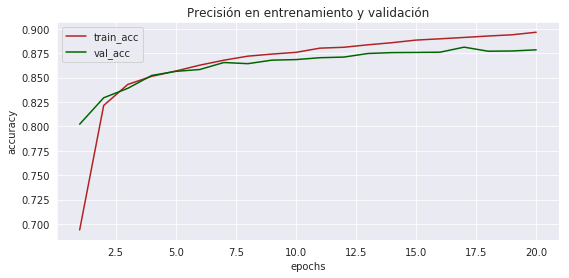

In [35]:
acc = results.history['acc']
val_acc = results.history['val_acc']
x = range(1, len(acc)+1)

plt.figure(figsize=(9,4))
sns.set_style('darkgrid')
sns.lineplot(x, y= acc, c="firebrick", \
             legend='brief', label="train_acc")
sns.lineplot(x, y=val_acc, c="darkgreen", \
             legend='brief', label="val_acc")
plt.legend(loc=0)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title("Precisión en entrenamiento y validación")

Text(0.5, 1.0, 'Pérdida en entrenamiento y validación')

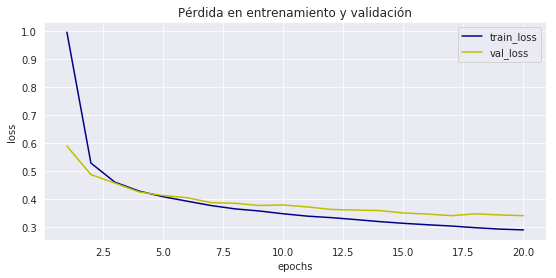

In [36]:
loss = results.history['loss']
val_loss = results.history['val_loss']
x = range(1, len(acc)+1)

plt.figure(figsize=(9,4))
sns.set_style('darkgrid')
sns.lineplot(x, y=loss, c="darkblue", \
             legend='brief', label="train_loss")
sns.lineplot(x, y=val_loss, c="y", \
             legend='brief', label="val_loss")
plt.legend(loc=0)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title("Pérdida en entrenamiento y validación")

* **Interpretación de los gráficos**

Los gráficos anteriores muestran la precisión y pérdida en los conjuntos de entrenamiento y validación, en cada iteración, es decir, para cada valor del parámetro **epoch**.

Es habitual que la red se comporte peor en los datos de validación que en los datos de entrenamiento, ya que el proceso de entrenamiento consiste precisamente en ajustar los pesos para que el error cometido en estos últimos se minimice. De esta forma, la red comienza a aprender patrones que son específicos de los datos de entrenamiento pero que no caracterizan otros datos. Este comportamiento se denomina **overfitting** (o **sobreajuste**). 

Por lo tanto, mediante los gráficos anteriores, podemos medir de alguna forma, si estamos en una situación de overfitting. que sería el caso en que en el conjunto de entrenamiento, la pérdida se mantiene constante o aumenta ligeramente, lo que hace que la _accuracy_ no aumente con el número de iteraciones.

Gracias a los gráficos anteriores, podemos obsevar que a simple vista, no nos encontramos ante una situación de sobreajuste, por lo que no sería necesario reducir el número de épocas.



> **Predicciones en el conjunto test**

---

In [37]:
y_pred = ANN.predict(x = x_test_ANN)
num_pred = np.argmax(y_pred, axis = 1)
num_pred[1:10]

array([2, 1, 1, 6, 1, 4, 6, 5, 7])

> **Representación gráfica de las imágenes del conjunto test con su clase real y predicha por la red**
---

In [0]:
def graph_images(images, class_true, class_pred):
    
    """
        Función que dibuja las distintas imagenes comparando la clase real con 
        la clase pronosticada por la red.
        
        Seleccionaremos un número aleatorio de imagenes a representar y, en 
        función de si se da la igualdad entre la clase real y predicha, el 
        borde (.spines()) de la imagen en cuestión tendrá color verde 
        (predicción correcta) o roja (predicción errónea)
    """
    
    n = sample(range(len(images)), 9)
    img = images[n]

    true = class_true[n]
    pred = class_pred[n]
    
    col = "green"
      
    fig, axes = plt.subplots(nrows = 3, ncols = 3)
    for row, a in enumerate(axes.flat):
        a.imshow(img[row].reshape(28,28), cmap='binary')
            
        xlabel = "Class: {}, Pred: {}".format(true[row], pred[row])
                         
        if true[row] != pred[row]:
            col = 'red'
                     
        a.spines['bottom'].set_color(col)
        a.spines['top'].set_color(col)
        a.spines['left'].set_color(col)
        a.spines['right'].set_color(col)
        col = "green"
                     
        a.set_xlabel(xlabel)
        a.set_xticks([])
        a.set_yticks([])
    
    plt.show()  

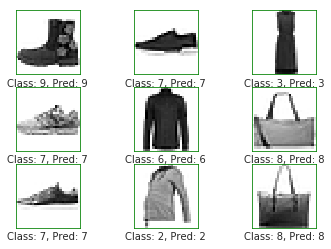

In [39]:
graph_images(x_test_ANN, np.argmax(y_test, axis = 1), num_pred)

* **Representación gráfica de las imágenes erróneamente clasificadas**

In [0]:
def graph_incorrect_pred(class_true, class_pred):
    
    """
        Función que imprime por pantalla 9 imágenes aleatorias clasificadas 
        incorrectamente por nuestro algoritmo Deep Learning utilizando la 
        función previamente creada y los array numéricos de la clase real y 
        pronosticada.
        
        Para ello, nos quedaremos con las imagenes del conjunto test cuya clase 
        real y predicha no coincide y llamaremos a la función anterior para que 
        dibuje esas imágenes.
    """

    incorrectas = (class_pred != class_true)
    
    incorrect_img = x_test[incorrectas]
    class_pred = class_pred[incorrectas]
    class_true = class_true[incorrectas]

    graph_images(incorrect_img, class_true, class_pred)

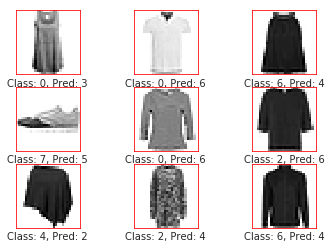

In [41]:
graph_incorrect_pred(np.argmax(y_test, axis=1), num_pred)

> **Conclusiones**
---

LLegados a este punto, podemos dar por finalizado el modelado de la **red neuronal artificial (ANN)**, gracias a la cual hemos obtenido una precisión del aproximadamente el 87%, siendo este un porcentaje elevado que nos indica que nuestro modelo ha obtenido buena precisión al clasificar las diferentes imágenes que componen los datos. 

El resultado obtenido nos lleva a pensar que estamos trabajando con un conjunto de datos sencillo puesto que, incluso una red neuronal simple nos permite obtener una alta precisión.

Ahora bien, a pesar de los buenos resultados, nos interesaría elevar, en la medida de lo posible, el número de imágenes bien clasificadas. Para ello, una red neuronal artificial no sería suficiente pues su complejidad no nos permitiría obtener mejoras significativas en cuanto a la precisión del modelo. Por lo tanto, para ello sería necesario acudir a otro tipo de redes más complejas : las **redes neuronales convolucionales (CNN)**. 

---
### Redes neuronales convolucionales (CNN)
---

* **Introducción a las redes convolucionales y diferencia con las redes neuronales ordinarias**

Las **redes neuronales convolucionales** son muy similares a las redes neuronales ordinarias como el perceptron multicapa; se componen de neuronas que tienen pesos y sesgos que pueden aprender. Cada neurona recibe algunas entradas, realiza un producto escalar y luego aplica una función de activación. Al igual que en el perceptron multicapa también vamos a tener una función de pérdida sobre la última capa, la cual estará totalmente conectada. Lo que diferencia a las redes neuronales convolucionales es que suponen explícitamente que las entradas son imágenes, lo que nos permite codificar ciertas propiedades en la arquitectura; permitiendo **ganar en eficiencia y reducir la cantidad de parámetros en la red**.  Así, de la misma forma que en la redes totalmente conectadas se establecía el número de neuronas, ahora debemos **establecer el número de filtros o máscaras que queremos aprender**.

* **Construcción de la red neuronal**

Explicamos a continuación el proceso de construcción de la red neuronal que posteriormente, implementaremos con código:

> - **FASE I: paso de la imagen de entrada a capa convolucionada**. Cada registro (imagen 28x28) se procesa en la primera capa convolucional usando los pesos de filtro. De esta manera se obtendrán como resultado tantas nuevas imágenes como filtros haya en la capa convolucional (64 en nuestro caso).

> - **FASE II: Pooling**. Se trata de una técnica habitualmente usada después de las capas de convolución. La más utilizada es conocida como `Max-Pooling` y toma el pixel que tiene más valor dentro de la ventana y lo coloca en la imagen de salida. Su función consiste en ir reduciendo progresivamente el tamaño de la representación, reduciendo así el número de parámetros, además de ser una forma eficiente de controlar el **sobreajuste**. El tamaño habitual de cada rejilla suele ser 2x2 con un stride de 2.

> - **FASE III: Convolución.** En esta nueva etapa, el número total de filtros a aprender serán 64.

> - **FASE IV: Pooling.** Nuevamente, reducimos la resolución de las representaciones (aproximadamente un 75%).

> - **FASE V: Capa Flatten.** A continuación, hemos de pasar la salida de la última capa anterior a una capa densa. Como estas capas procesan vectores, que son 1D, y la entrada es un tensor 3D, hemos de aplanar el tensor por medio de la capa `Flatten()`, que también proporciona Keras. 

> - **FASE V: Capa Densa.** Finalmente, el vector 1D se usará como entrada a la capa **fully-connected** (capa densa) con 64 neuronas. La salida de esta capa forma la entrada de la siguiente capa completamente conectada con 10 neuronas, una para cada una de las clases.

In [42]:
CNN = Sequential()

CNN.add(Conv2D(64, (3,3), activation='relu', input_shape=(28, 28, 1)))
CNN.add(MaxPooling2D((2,2)))
CNN.add(Conv2D(64, (3,3), activation='relu'))
CNN.add(MaxPooling2D((2,2)))

CNN.add(Flatten())
CNN.add(Dense(64, activation='relu'))
CNN.add(Dense(10, activation='softmax'))

W0815 08:04:59.466867 140019154036608 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



In [43]:
CNN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 64)                102464    
_________________________________________________________________
dense_14 (Dense)             (None, 10)                650       
Total para

> **Comentario acerca del número de parámetros en cada capa**

La primera capa de la red es una capa convolucional y su tamaño de filtro es 3x3, esto implica que por cada filtro tendremos 9 parámetros. Por otro lado, estamos calculando 64 filtros o máscaras, por lo que tendremos 9x64 = 576 parámetros. Ahora bien, debido a que cada filtro tiene su propio parámetro de sesgo tendremos finalmente 576+64 = **640 parámetros**.

La siguiente capa es una capa de pooling. Como hemos comentado, esta capa no tiene ningún parámetro que aprender puesto que únicamente lleva a cabo una reducción de los *feature maps* calculados por la capa anterior.

En la segunda capa de convolución, nuevamente aplicaremos filtros de 3x3 y, en este caso, serán un total de 64 filtros. Así, tendremos un total de 576 parámetros (9x64). Sin embargo ahora la entrada tiene 64 canales que corresponden con los 64 mapas de características (*feature maps*) anteriores, por tanto tenemos, 576x64 = 36864 parámetros que, sumados al sesgo por cada nuevo filtro hacen los **36928 parámetros**.

Nuevamente nos encontramos con una capa de pooling que recibe los 64 *feature maps* de la capa convolucionada anterior.

Pasamos ahora a la capa densa (totalmente conectada). De entrada tenemos 64 mapas de características de tamaño 5x5. Al aplanar todos esos mapas obtenemos un vector de 1600 posiciones (neuronas).  Ahora bien, esta capa de neuronas se conecta totalmente con una capa densa de 64 neuronas, por lo que tendremos 25x64x64 = 102400 parámetros que aprender más un parámetro de sesgo por neurona que hacen los **102464 parámetros**.

La última capa tiene un razonamiento similar; 64 neuronas se conectan con 10 neuronas que hacen referencia a cada una de posibles clases de la variable objetivo, obteniendo así 640 parámetros que, más sus correspondientes sesgos, dan un total de **650 parámetros**.

* **Compilación del modelo**

Hasta ahora solo hemos definido la estructura de la red, pero no hemos dado ninguna información acerca de cómo se llevará a cabo el entrenamiento. Para ello, hemos de indicarle a Keras algunas características adicionales, tales como el optimizador que permitirá modificar los pesos de la red, qué función de coste o pérdida se usará para dirigir esta optimización, y la métrica que usaremos para medir cómo se va comportando la red a medida que se entrena.

Generalmente, los modelos de redes neuronales son entrenados por un optimizador de **descenso de gradiente estocástico**; a lo largo de nuestro trabajo usaremos los optimizares *Adam* y *RMSProp*. Ambos nos permiten trabajar con el parámetro de la tasa de aprendizaje (***learning_rate***); este parámetro, fácilmente ajustable, cuanto menor sea más tardará la red en entrenar y aprender pero se alcanzará una mayor precisión en el conjunto de aprendizaje. 

En este primer ejemplo, usaremos el optimizador *Adam* con un valor del parámetro *learning_rate* de 0.0001. En cuanto a la métrica que evaluará como de bueno está siendo el entrenamiento, usaremos la métrica *accuracy* que determina la tasa de clasificación correcta en las predicciones.


In [0]:
opt = Adam(lr = 1e-4)

CNN.compile(optimizer = opt,
            loss = 'categorical_crossentropy',
            metrics = ['accuracy'])

* **Entrenamiento de la red neuronal**

Ahora que ya hemos definido la estructura de la red, el optimizador con su tasa de aprendizaje asociada y las distintas metricas, ya podemos entrenar la red.
Para ello, haremos uso de la función `.fit()` y tendremos que fijar el valor de dos hiperparámetros: **epoch** (iteraciones a realizar) y **batch_size** (cada cuántos ejemplos el algoritmos actualiza los pesos).

In [45]:
CNN.fit(x_train_CNN, y_train, epochs = 10, batch_size = 64)

Epoch 1/10
60000/60000 [==============================] - 43s 721us/step - loss: 0.8153 - acc: 0.7235
Epoch 2/10
60000/60000 [==============================] - 43s 713us/step - loss: 0.4963 - acc: 0.8202
Epoch 3/10
60000/60000 [==============================] - 43s 715us/step - loss: 0.4420 - acc: 0.8432
Epoch 4/10
60000/60000 [==============================] - 43s 720us/step - loss: 0.4125 - acc: 0.8541
Epoch 5/10
60000/60000 [==============================] - 43s 709us/step - loss: 0.3883 - acc: 0.8628
Epoch 6/10
60000/60000 [==============================] - 44s 731us/step - loss: 0.3703 - acc: 0.8700
Epoch 7/10
60000/60000 [==============================] - 44s 725us/step - loss: 0.3560 - acc: 0.8735
Epoch 8/10
60000/60000 [==============================] - 43s 722us/step - loss: 0.3437 - acc: 0.8775
Epoch 9/10
60000/60000 [==============================] - 43s 720us/step - loss: 0.3335 - acc: 0.8824
Epoch 10/10
60000/60000 [==============================] - 43s 720us/step - loss: 

* **Evaluación del modelo**

Tras el entrenamiento podemos evaluar el modelo sobre los datos de test:

In [46]:
test_loss, test_acc = CNN.evaluate(x_test_CNN, y_test)
print("Precisión alcanzada por el algoritmo Deep Learning en el conjunto test:", 
      round(100*test_acc, 2), "%")

10000/10000 [==============================] - 2s 238us/step
Precisión alcanzada por el algoritmo Deep Learning en el conjunto test: 87.58 %


* **Predicciones**

In [47]:
y_pred = CNN.predict(x = x_test_CNN)

num_pred = np.argmax(y_pred, axis=1)
num_pred[1:10]

array([2, 1, 1, 6, 1, 4, 6, 5, 7])

* **Representación gráfica de las imágenes del conjunto test con su clase real y predicha por la red**

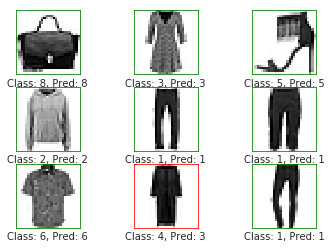

In [48]:
graph_images(x_test_CNN, np.argmax(y_test, axis=1), num_pred)

* **Representación gráfica de las imágenes erróneamente clasificadas**

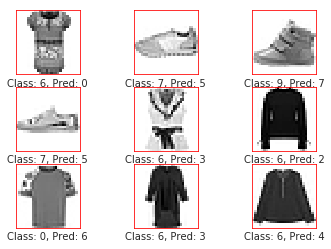

In [49]:
graph_incorrect_pred(np.argmax(y_test, axis=1), num_pred)

---
#### Normalización - Batch Normalization
---

La técnia `Batch Normalizacion` consiste en normalizar la salida de cada capa por cada mini-batch. Se suele aplicar antes de la función de activación controlando así que la salida de las operaciones lineales saturen a la neurona y no se produzca el *vanishing*.

Entre sus múltiples ventajas destaca la posibilidad de usar una *learning rate* mayor además de ser considerado un método de regularización evitando así tener que usar otras técnicas de regularización. En cuanto a los inconvenientes, sí es cierto que las predicciones son más lentas.

Así pues, aplicaremos dicha técnicas tras cada convolución y aumentaremos la tasa de aprendizaje a 0.001 (un 10% mayor). 

Incorporamos ahora un nuevo hiperparámetro al optimizador *Adam*, se trata del parámetro `learning rate decay`. Es cierto que el mejor *learning rate*  en general es aquel que disminuye a medida que el modelo se acerca a una solución; usaremos este nuevo hiperparámetro para conseguir este efecto. Con este hiperparámetro conseguimos disminuir el *learning rate* a medida que van pasando *epochs* para permitir que el aprendizaje avance más rápido al principio con *learning rates* más grandes. A medida que se avanza, se van haciendo ajustes cada vez más pequeños para facilitar que el entrenamiento converja al mínimo de la función de pérdida (función *loss*).

In [50]:
CNN = Sequential()

CNN.add(Conv2D(64, (3,3), input_shape=(28, 28, 1)))
CNN.add(BatchNormalization())
CNN.add(Activation('relu'))
CNN.add(MaxPooling2D((2,2)))
CNN.add(Conv2D(64, (3,3)))
CNN.add(BatchNormalization())
CNN.add(Activation('relu'))
CNN.add(MaxPooling2D((2,2)))

CNN.add(Flatten())
CNN.add(Dense(64))
CNN.add(BatchNormalization())
CNN.add(Activation('relu'))
CNN.add(Dense(10, activation='softmax'))
        
opt = Adam(lr=1e-3, decay=1e-6)

CNN.compile(optimizer = opt,
            loss = 'categorical_crossentropy',
            metrics = ['accuracy'])

W0815 08:14:54.470423 140019154036608 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.



> **Validación del modelo: conjunto de entrenamiento, validación y test**

Con el objetivo de monitorizar la métrica *accuracy* durante la etapa de aprendizaje, necesitaremos tener un conjunto de datos con los que determinar cómo de bueno es el modelo que estamos entrenando, con unos parámetros fijos. De esta forma podremos ajustar estos parámetros para mejorar el rendimiento, así como, detectar la presencia de **overfitting** en nuestro modelo que podremos posteriormente subsanar recurriendo a las técnicas de regularización.

Crearemos por tanto un conjunto de validación formado por el 30% del conjunto de entrenamiento, es decir, unas 18000 muestras.

>> **Definición del conjunto de validación**

In [0]:
val_size = int(0.3 * len(x_train_CNN))

x_val_CNN = x_train_CNN[:val_size]
y_val = y_train[:val_size]

x_train_CNN = x_train_CNN[val_size:]
y_train = y_train[val_size:]

>> **Validación del modelo**

In [52]:
train_val = CNN.fit(x_train_CNN, y_train, epochs = 10, batch_size = 64,
                    validation_data=(x_val_CNN, y_val))

Train on 42000 samples, validate on 18000 samples
Epoch 1/10
42000/42000 [==============================] - 74s 2ms/step - loss: 0.4226 - acc: 0.8550 - val_loss: 0.3598 - val_acc: 0.8693
Epoch 2/10
42000/42000 [==============================] - 73s 2ms/step - loss: 0.2783 - acc: 0.8972 - val_loss: 0.2936 - val_acc: 0.8926
Epoch 3/10
42000/42000 [==============================] - 73s 2ms/step - loss: 0.2367 - acc: 0.9134 - val_loss: 0.2955 - val_acc: 0.8902
Epoch 4/10
42000/42000 [==============================] - 74s 2ms/step - loss: 0.2028 - acc: 0.9260 - val_loss: 0.3595 - val_acc: 0.8691
Epoch 5/10
42000/42000 [==============================] - 73s 2ms/step - loss: 0.1808 - acc: 0.9336 - val_loss: 0.2590 - val_acc: 0.9073
Epoch 6/10
42000/42000 [==============================] - 73s 2ms/step - loss: 0.1550 - acc: 0.9438 - val_loss: 0.2737 - val_acc: 0.9043
Epoch 7/10
42000/42000 [==============================] - 74s 2ms/step - loss: 0.1357 - acc: 0.9509 - val_loss: 0.3408 - val_acc

>>* **Representación gráfica:** comparación de la precisión y la función de pérdida alcanzada para cada iteración en cada conjunto.

Text(0.5, 1.0, 'Precisión en entrenamiento y validación')

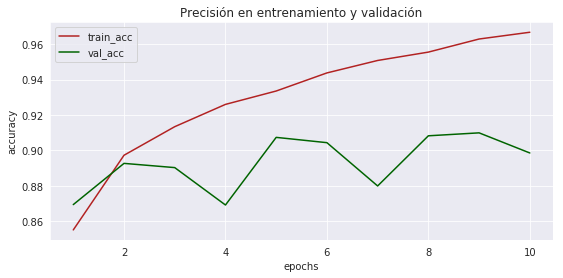

In [53]:
ent_acc = train_val.history['acc']
val_acc = train_val.history['val_acc']

plt.figure(figsize=(9,4))
sns.set_style('darkgrid')
sns.lineplot(x=range(1, 11), y=ent_acc, c="firebrick", \
             legend='brief', label="train_acc")
sns.lineplot(x=range(1, 11), y=val_acc, c="darkgreen", \
             legend='brief', label="val_acc")
plt.legend(loc=0)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title("Precisión en entrenamiento y validación")

Text(0.5, 1.0, 'Pérdida en entrenamiento y validación')

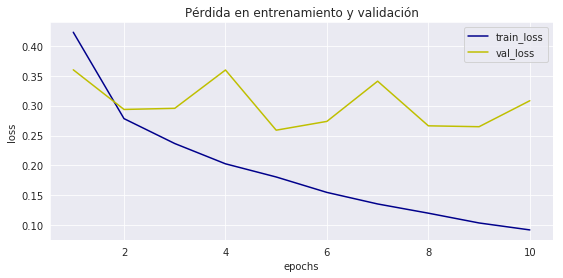

In [54]:
ent_loss = train_val.history['loss']
val_loss = train_val.history['val_loss']

plt.figure(figsize=(9,4))
sns.set_style('darkgrid')
sns.lineplot(x=range(1, 11), y=ent_loss, c="darkblue", \
             legend='brief', label="train_loss")
sns.lineplot(x=range(1, 11), y=val_loss, c="y", \
             legend='brief', label="val_loss")
plt.legend(loc=0)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title("Pérdida en entrenamiento y validación")

>> Observamos que la precisión en el conjunto de entrenamiento va aumentando a medida que se incrementa el número de iteraciones, sin embargo, la función de perdida en el conjunto de validación no va decreciendo paralelemante a lo que lo hace la del conjunto de aprendizaje, es decir, la red no está aprendiendo patrones durante su etapa de entrenamiento que se puedan generalizar para otro set de datos haciendo que el conjunto de aprendizaje mejore su precisión iteración a iteración mientas que la precisión en el conjunto de validación no presenta un comportamiento monótonamente creciente (resp. función de pérdida decreciente).

>>> **Rendimiento del modelo en el conjunto test**

In [55]:
test_loss, test_acc = CNN.evaluate(x_test_CNN, y_test)
print("Precisión alcanzada aplicando Batch-Normalización en el conjunto test:", 
      round(100*test_acc, 2), "%")

10000/10000 [==============================] - 5s 499us/step
Precisión alcanzada aplicando Batch-Normalización en el conjunto test: 89.7 %


>> **Conclusión:** observamos que aplicando la técnica de normalización con sus correspondientes modificaciones con respecto al modelo inicial hemos alcanzado una **precisión mayor en nuestro conjunto test** aunque el **esfuerzo computacional también superior**. Además, observamos un claro problema de sobreajuste que intentaremos solucionar.

---
#### Regularización
---

En modelos anteriores hemos visto que tras un número no muy grande de iteraciones (*epochs*) la precisión en el conjunto de validación alcanzaba un máximo y a partir de ahí empezaba a degradarse. Es decir, tras un número pequeño de iteraciones, los modelos comienzan a sobreajustarse a los datos de entrenamiento sin que haya dado tiempo a aprender suficientes patrones útiles que puedan ser aplicados sobre nuevos datos.

Dicho de otra forma, cuando tras pocas iteraciones la **generalización** deja de mejorar y las métricas de validación comienzan a empeorar nos encontramos ante un caso de ***overfitting***; el modelo comienza a aprender patrones que son específicos del conjunto de aprendizaje pero que no caracterizan otros datos.

Así pues en este apartado trabajaremos con distintas técnicas que nos permiten luchar con el problema del sobreajuste, son las que se conocen como **técnicas de regularización** y trabajaremos con 3 de ellas:

* ***Data Augmentation***
* ***DropOut***
* ***Early Stopping***

---
##### Data Augmentation
---

La forma más simple de reducir el problema del sobreajuste es incrementando el tamaño del conjunto de entrenamiento.

Esta técnica de regularización abarca una amplia gana de métodos para generar "nuevas" muestras de entrenamiento a partir de las originales por medio de operaciones básicas como traslación, rotación, escalado, volteado, etc.  *Keras* nos proporciona la clase **`ImageDataGenerator`** que aplica varias de estas transformaciones al conjunto de datos de manera automática.

<img src='data_augmentation.PNG' width=50%>

Nuestro objetivo, por tanto, al aplicar esta técnica de regularización es **aumentar la generalización del modelo**.

In [0]:
image_generator = ImageDataGenerator(
            rotation_range=10,
            zoom_range = 0.05, 
            width_shift_range=0.05,
            height_shift_range=0.05,
            horizontal_flip=False,
            vertical_flip=False, 
            data_format="channels_last",
            zca_whitening=True)

Una vez creada la instancia debemos ejercutar el método fit sobre el conjunto de datos.

> **Nota:** dicha técnica de regularización se realiza SOLO en el conjunto de entrenamiento, ya que ayuda a que el modelo sea más generalizado y robusto. Así, no tiene sentido aplicar *Data Augmentation* sobre el conjunto de validación y test.

In [0]:
image_generator.fit(x_train_CNN, augment=True)

El siguiente paso, tal y como muestra el diagrama adjunto, es transformar un subconjunto aleatorio de muestras del conjunto de entrenamiento. Tomamos por ejemplo, 4800 muestras aleatorias de nuestra conjunto de entrenamiento, es decir, un 10% del total.

In [0]:
index = np.random.randint(len(x_train_CNN), size=4800)
x_train_CNN_augmented = x_train_CNN[index].copy()
y_train_augmented = y_train[index].copy()
x_train_CNN_augmented = image_generator.flow(x_train_CNN_augmented, 
                                             np.zeros(4800),
                                             batch_size=4800, 
                                             shuffle=False).next()[0]

Como último paso agregamos estas "nuevas" muestras a nuestro conjunto de entrenamiento y volvemos a entrenar la red sobre el nuevo set de datos, analizando nuevamente su comportamiento sobre el conjunto de validación. De esta forma tenemos una muestra de entrenamiento de tamaño 46800 (42000 iniciales más 4800 generadas) además del conjunto de validación correspondiente al 30% del tamaño de aprendizaje inicial, 18000 muestras.

Previamente a proceder con el entrenamiento, validación y evaluación del modelo creado vamos a añadir a nuestro modelo una última técnica (o modificación) de regularización: `dropout`.

In [0]:
x_train_CNN = np.concatenate((x_train_CNN, x_train_CNN_augmented))
y_train = np.concatenate((y_train, y_train_augmented))

---
##### Dropout
---

Se trata de una de las técnicas de regularización más efectivas centrándose en la idea de romper patrones que no son significativos mediante la introducción de ruido en los valores de salida de una capa y que la red empieza a memorizar si no estuviera este ruido presente.

Es decir, esta técnica consiste en la eliminación de un número de características de salida de la capa durante el entrenamiento de manera que las neuronas con las que está conectada la neurona afectada han de aprender la misma representación sin considerar su trabajo conjunto, lo que lleva a disponer de **representaciones internas más robustas e independientes**.

Tras esta pequeña introducción, ya estamos en condiciones de proceder a entrenar y validar nuestro modelo:

In [62]:
CNN = Sequential()

CNN.add(Conv2D(64, (3,3), input_shape=(28, 28, 1)))
CNN.add(BatchNormalization())
CNN.add(Activation('relu'))
CNN.add(MaxPooling2D((2,2)))
CNN.add(Conv2D(64, (3,3)))
CNN.add(BatchNormalization())
CNN.add(Activation('relu'))
CNN.add(MaxPooling2D((2,2)))
CNN.add(Dropout(0.25))

CNN.add(Flatten())
CNN.add(Dense(64))
CNN.add(BatchNormalization())
CNN.add(Activation('relu'))
CNN.add(Dropout(0.5))
CNN.add(Dense(10, activation='softmax'))

CNN.compile(optimizer=opt,
            loss='categorical_crossentropy',
            metrics=['accuracy'])

train_val_dropout = CNN.fit(x_train_CNN, y_train, epochs=10, batch_size=64, 
                            validation_data=(x_val_CNN, y_val))

test_loss, test_acc = CNN.evaluate(x_test_CNN, y_test)
print("Precisión alcanzada por la red normalizada aplicando \nData Augmentation \
       sobre el conjunto test:", 
      round(100*test_acc, 2), "%")

Train on 46800 samples, validate on 18000 samples
Epoch 1/10
46800/46800 [==============================] - 84s 2ms/step - loss: 0.6694 - acc: 0.7578 - val_loss: 0.4167 - val_acc: 0.8458
Epoch 2/10
46800/46800 [==============================] - 82s 2ms/step - loss: 0.4888 - acc: 0.8264 - val_loss: 0.3528 - val_acc: 0.8703
Epoch 3/10
46800/46800 [==============================] - 83s 2ms/step - loss: 0.4431 - acc: 0.8425 - val_loss: 0.3270 - val_acc: 0.8812
Epoch 4/10
46800/46800 [==============================] - 83s 2ms/step - loss: 0.4060 - acc: 0.8536 - val_loss: 0.3082 - val_acc: 0.8884
Epoch 5/10
46800/46800 [==============================] - 83s 2ms/step - loss: 0.3896 - acc: 0.8598 - val_loss: 0.2863 - val_acc: 0.8944
Epoch 6/10
46800/46800 [==============================] - 82s 2ms/step - loss: 0.3704 - acc: 0.8665 - val_loss: 0.2906 - val_acc: 0.8909
Epoch 7/10
46800/46800 [==============================] - 83s 2ms/step - loss: 0.3621 - acc: 0.8699 - val_loss: 0.3001 - val_acc

> **Conclusiones** 


 
- Observamos que no hemos conseguido aumentar nuestra precisión en el conjunto test habiendo aumentado el número de muestras en el conjunto de aprendizaje y, por tanto, tampoco  la posibilidad de aprender nuevos patrones que sirvan para obtener una mejor tasa de acierto sobre el conjunto de datos del test. Esto se explica debido a  la técnica de regularización *dropout* introducida al final de dos capas de neuronas, pues estamos introduciendo ruido en la salida de las mismas y por lo tanto, suprimiendo  capacidad de transmisión de las neuronas en las capas. De todos modos, la disminución en cuanto a la precisión sobre el conjunto test no es sgnificativa, pues hemos pasado de obtener una precisión de  un 89.7% a un 89.57%. 


- Lo más importante es que combinando las técnicas de *Data Augmentation* y *dropout* hemos acabado con el sobreajuste. A continuación lo podremos observar gráficamente pero atendiendo a las métricas que podemos observar en la salida anterior vemos que la precisión en ambos conjuntos, entrenamiento y validación, aumenta a la vez no sobreajustándose el modelo sobre los datos de entrenamiento sino que es capaz de generalizar sobre datos con los que no entrena.

- Sin embargo observamos que en ciertas iteraciones nuestro modelo se comporta alcanzando un peor ajuste que en iteraciones anteriores aunque inmediantamente se mejore la tasa de acierto en *epochs* superiores.

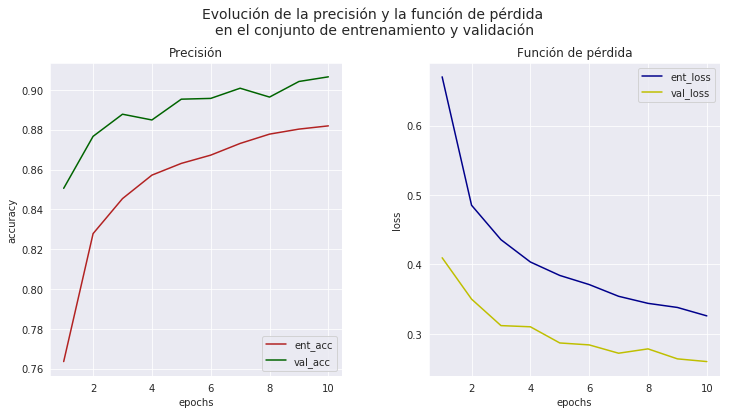

In [61]:
ent_acc = train_val_dropout.history['acc']
ent_loss = train_val_dropout.history['loss']
val_acc = train_val_dropout.history['val_acc']
val_loss = train_val_dropout.history['val_loss']

fig = plt.figure(figsize=(12,6)) 
title = fig.suptitle(
    "Evolución de la precisión y la función de pérdida \nen el conjunto de entrenamiento y validación", 
    fontsize=14) 
fig.subplots_adjust(top=0.85, wspace=0.3) 

ax1 = fig.add_subplot(1,2,1) 
ax1.set_title("Precisión") 
ax1.set_xlabel("epochs") 
ax1.set_ylabel("accuracy") 
sns.lineplot(x=range(1, 11), y=ent_acc, color="firebrick", ax=ax1, 
             legend="brief", label="ent_acc")
sns.lineplot(x=range(1, 11), y=val_acc, color="darkgreen", ax=ax1, 
             legend="brief", label="val_acc")
plt.legend(loc=4)

ax2 = fig.add_subplot(1,2,2) 
ax2.set_title("Función de pérdida") 
ax2.set_xlabel("epochs") 
ax2.set_ylabel("loss")
sns.lineplot(x=range(1, 11), y=ent_loss, color="darkblue", ax=ax2, 
             legend="brief", label="ent_loss")
sns.lineplot(x=range(1, 11), y=val_loss, color="y", ax=ax2, 
             legend="brief", label="val_loss")
plt.legend(loc=1)


---
##### Early Stopping
---

Introducimos ahora una nueva técnica de regularización para la cual necesitaremos un subconjunto de validación que no podremos usar para entrenar. 

De esta forma y durante el proceso iterativo de optimización de los parámetros de la red, se comparán los errores obtenidos con los datos de entrenamiento y con los datos de validación. En el caso de que durante sucesivas iteraciones, el error cometido sobre el conjunto de entrenamiento disminuya, mientras que el error en el conjunto de validación aumente, se detendrá el proceso de ajuste como un criterio de parada adicional.

Así, podemos distinguir dos fases en este proceso:

* Entrenamos el modelo usando la técnica de regularización `early stopping` obteniendo así el número de iteraciones óptimas.

* Entrenamos el modelo con todos los datos con el número de iteraciones alcanzado en la etapa anterior.

> **Fase I**

Consideraremos el subconjunto de validación que hemos tomado en modelos anteriores. En este caso, aumentaremos el número de iteraciones a realizar y fijaremos como criterio de parada el siguiente: _si durante 3 iteraciones el error en el conjunto de entrenamiento disminuye y el error en el conjunto de validación aumenta, pararemos el proceso de ajuste quedándonos con un número de iteraciones óptimas_. En el modelo anterior observábamos que la precisión en el conjunto de validación disminuía en ciertas iteraciones (en relación a las anteriores) e inmediatamente aumentaba lo que nos llevaba a aceptar dicho modelo como óptimo; ahora incrementaremos el número de iteraciones a 20 aunque eso suponga un esfuerzo computacional mayor.

Fijamos el número de iteraciones que se pueden dejar pasar sin que se haya registrado una mejoría y nos disponemos a entrenar nuestra red sobre el conjunto de entrenamiento reducido y observando la tasa de acierto incorrecta (`val_loss`) cometida sobre el conjunto de validación (será la métrica que debe ser monitorizada).

In [63]:
CNN.fit(x_train_CNN, y_train, epochs=20, batch_size=64, 
        validation_data=(x_val_CNN, y_val),
        callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

Train on 46800 samples, validate on 18000 samples
Epoch 1/20
46800/46800 [==============================] - 83s 2ms/step - loss: 0.3276 - acc: 0.8810 - val_loss: 0.2573 - val_acc: 0.9054
Epoch 2/20
46800/46800 [==============================] - 82s 2ms/step - loss: 0.3154 - acc: 0.8862 - val_loss: 0.2489 - val_acc: 0.9094
Epoch 3/20
46800/46800 [==============================] - 82s 2ms/step - loss: 0.3134 - acc: 0.8858 - val_loss: 0.2700 - val_acc: 0.8948
Epoch 4/20
46800/46800 [==============================] - 83s 2ms/step - loss: 0.3069 - acc: 0.8895 - val_loss: 0.2670 - val_acc: 0.8974
Epoch 5/20
46800/46800 [==============================] - 82s 2ms/step - loss: 0.3005 - acc: 0.8907 - val_loss: 0.2568 - val_acc: 0.9042


> Una manera de recuperar el número de iteraciones óptimas alcanzadas en la **Fase I** es de la siguiente forma:

In [0]:
num_epochs_early_stopping = len(CNN.history.epoch)

> **Fase II**

Alcanzado el número de iteraciones óptimas que nos devuelve la salida anterior, entrenamos el modelo fijando el número de iteraciones óptimas alcanzadas con todo el conjunto de datos, es decir entrenamiento + validación, y evaluamos su rendimiento en el conjunto test. 

In [66]:
x_train_val_CNN =  np.concatenate((x_train_CNN, x_val_CNN))
y_train_val_CNN = np.concatenate((y_train, y_val))

CNN.fit(x_train_val_CNN, y_train_val_CNN, 
        epochs=num_epochs_early_stopping, batch_size=64)

test_loss, test_acc = CNN.evaluate(x_test_CNN, y_test)
print("Precisión final alcanzada por la red normalizada y tras aplicar técnicas de regularización: ", 
      round(100*test_acc, 2), "%")

Epoch 1/5
64800/64800 [==============================] - 108s 2ms/step - loss: 0.3049 - acc: 0.8895
Epoch 2/5
64800/64800 [==============================] - 108s 2ms/step - loss: 0.2999 - acc: 0.8912
Epoch 3/5
64800/64800 [==============================] - 109s 2ms/step - loss: 0.2952 - acc: 0.8936
Epoch 4/5
64800/64800 [==============================] - 108s 2ms/step - loss: 0.2902 - acc: 0.8946
Epoch 5/5
10000/10000 [==============================] - 5s 540us/step
Precisión final alcanzada por la red normalizada y tras aplicar técnicas de regularización:  90.83 %


---

### Redes Convolucionales Pre-entrenadas
---

Una aproximación muy común y efectivo cuando se trabaja con Deep Learning sobre conjuntos de datos pequeños, como es nuestro caso, sería el reutilizar **redes pre-entrenadas** que no es más que una red grabada que ha sido entrenada sobre un conjunto de datos grande.

De esta forma, si el conjunto de datos original es lo suficientemente grande y general, la jerarquía de características espaciales que ha aprendido la red pre-entrenada puede ser útil como modelo genérico de nuestro mundo visual y, por lo tanto, sus características pueden ser de ayuda incluso en aquello problemas que involucren clases totalmente distintas a las de la tarea original. A esta portabilidad de características aprendidas entre diferentes problemas se le llama ***Transfer Learning*** o ***Transferencia de Aprendizaje***.


-  ***Transfer Learning***

Esta técnica consiste en usar representaciones aprendidas por otras redes para extraer características interesantes de nuevas muestras. Tras esta extracción, se usa la nueva representación dada por estas características para alimentar un nuevo clasificador, que (esta vez sí) será entrenado desde cero.

Las CNN utilizadas para clasificar las imágenes constan de dos partes bien diferenciadas, la primera comienza por una serie de capas alternadas de convolución y pooling (**base convolucional**) y acaban con un clasificador de capas densas.  Por lo tanto, para aplicar dicha técnica a nuestros datos, vamos a aprovechar la base convolucional de la red pre-entrenada para obtener las nuevas representaciones y entrenaremos un nuevo codificador en la última parte.

La razón de ignorar la parte del clasificador denso se debe a que las representaciones aprendidas en la base convolucional son más **genéricas**, por lo que podrían ser útiles para todo tipo de problemas de visión artificial.
Por su parte, las representaciones aprendidas por el clasificador son mucho más **específicas** y se encuentran relacionadas con el problema que se está tratando.

Por otra parte, en cuanto al **nivel de generalidad** de las representaciones extraídas por las capas convolucionales dependen de la **profundidad** de las capas. De esta forma, las primeras capas extraen mapas de características muy genéricas (colores, texturas, etc.), mientras que las más profundas extraen conceptos abstractos más elevados (ojos, boca, etc.). Por ello, si el conjunto de datos sobre el que estamos trabajando difiere del original, sería conveniente usar solo las primeras capas de la base convolucional.


Para nuestro problema, vamos a implementar el modelo pre-entrenado **`VGG16`**, que es una arquitectura de ConvNets ampliamente utilizada para ImageNet.


###   Preprocesamiento de los datos
---
Vamos a comenzar por el procesamiento de nuestros datos, de manera que se adapten a la entrada de la red pre-entrenada que vamos a utilizar. En primer lugar, dado que nuestros datos han sufrido modificaciones durante la creación de **redes neuronales artificiales** y **redes neuronales convolucionales**, vamos volver a descargarlos y, sobre estos, llevaremos a cabo las modificaciones que sean oportunas.

In [0]:
(x_train, y_train), (x_test, y_test) =  tf.keras.datasets.fashion_mnist.load_data()

> **Validación del modelo: conjunto de entrenamiento, validación y test**

Con el objetivo de monitorizar la métrica *accuracy* durante la etapa de aprendizaje, necesitaremos tener un conjunto de datos con los que determinar cómo de bueno es el modelo que estamos entrenando, con unos parámetros fijos. De esta forma podremos ajustar estos parámetros para mejorar el rendimiento, así como, detectar la presencia de **overfitting** en nuestro modelo.

Crearemos por tanto un conjunto de validación formado por el 30% del conjunto de entrenamiento, es decir, unas 18000 muestras.

>> **Definición del conjunto de validación**

In [68]:
val_size = int(0.3 * len(x_train))
x_val = x_train[:val_size]
y_val = y_train[:val_size]
x_train = x_train[val_size:]
y_train = y_train[val_size:]

print("Dimensiones: ")
print("- Conjunto de entrenamiento:\t{}".format(x_train.shape))
print("- Conjunto de validación:\t{}".format(x_val.shape))
print("- Conjunto de predicción:\t{}".format(x_test.shape))


Dimensiones: 
- Conjunto de entrenamiento:	(42000, 28, 28)
- Conjunto de validación:	(18000, 28, 28)
- Conjunto de predicción:	(10000, 28, 28)


---
Una vez definidos los conjuntos necesarios para el entrenamiento, validación y predicciones de nuestro modelo, pasamos a la **adpatación de las dimensiones**. 

Una red convolucional, toma como dato de entrada un tensor de la forma `(image_height, image_width, image_channels)`. En este caso, el modelo `VGG16` requiere que  `(image_height, image_width)`sea como mínimo de dimensión (32,32) y, nuestros datos tienen una dimensión de (28,28), por lo que, debemos aumentar dimensión de las imágenes, en nuestro caso aumentaremos su tamaño a (48,48) . Además, en cuanto al número de canales utilizados, a diferencia del modelo definido anteriormente para el que únicamente utiizamos un solo canal (gris) en las imágenes, en este caso, debemos usar 3 canales.

Por otro lado, aprovecharemos en ambas definiciones para normalizar el contenido de estas imágenes, están en escalas de grises con valores uint8 entre 0 y 255, y las pasaremos a valores float32 en  [0,1]), algo aconsejable cuando se trabaja con este tipo de modelos.

Además, vamos a convertir las etiquetas (que vienen en el dataset como valores enteros), en vectores binarios para que se correspondan con la salida que nuestra red puede proporcionar. Para ello haremos uso de la función `.to_categorical()` puesto que Keras necesita que todas las etiquetas sean codificadas de forma numérica, lo que significa que hemos de añadir una columna numérica a cada muestra para representar la clase a la que pertenece de forma binaria (es lo que se llama **_one-hot-encoding_**):

---

* **Aplanamiento de los datos**

In [69]:
x_train = x_train.reshape((42000, 28*28))
x_val = x_val.reshape((18000, 28*28))
x_test = x_test.reshape((10000, 28*28))

print("Dimensiones: ")
print("- Conjunto de entrenamiento:\t{}".format(x_train.shape))
print("- Conjunto de validación:\t{}".format(x_val.shape))
print("- Conjunto de predicción:\t{}".format(x_test.shape))


Dimensiones: 
- Conjunto de entrenamiento:	(42000, 784)
- Conjunto de validación:	(18000, 784)
- Conjunto de predicción:	(10000, 784)


---
* **Conversión de datos en 3 canales**

In [70]:
x_train = np.dstack([x_train] * 3)
x_val = np.dstack([x_val] * 3)
x_test = np.dstack([x_test] * 3)

print("Dimensiones: ")
print("- Conjunto de entrenamiento:\t{}".format(x_train.shape))
print("- Conjunto de validación:\t{}".format(x_val.shape))
print("- Conjunto de predicción:\t{}".format(x_test.shape))

Dimensiones: 
- Conjunto de entrenamiento:	(42000, 784, 3)
- Conjunto de validación:	(18000, 784, 3)
- Conjunto de predicción:	(10000, 784, 3)


---
* **Remodelación de datos**

In [71]:
x_train = x_train.reshape(-1, 28,28,3)
x_val = x_val.reshape (-1,28,28,3)
x_test = x_test.reshape (-1,28,28,3)

print("Dimensiones: ")
print("- Conjunto de entrenamiento:\t{}".format(x_train.shape))
print("- Conjunto de validación:\t{}".format(x_val.shape))
print("- Conjunto de predicción:\t{}".format(x_test.shape))


Dimensiones: 
- Conjunto de entrenamiento:	(42000, 28, 28, 3)
- Conjunto de validación:	(18000, 28, 28, 3)
- Conjunto de predicción:	(10000, 28, 28, 3)


---
* **Redimensión de los datos**

In [72]:
x_train = np.asarray([img_to_array(array_to_img(im, scale = False).resize((48,48))) for im in x_train])
x_val = np.asarray([img_to_array(array_to_img(im, scale = False).resize((48,48))) for im in x_val])
x_test = np.asarray([img_to_array(array_to_img(im, scale = False).resize((48,48))) for im in x_test])

print("Dimensiones: ")
print("- Conjunto de entrenamiento:\t{}".format(x_train.shape))
print("- Conjunto de validación:\t{}".format(x_val.shape))
print("- Conjunto de predicción:\t{}".format(x_test.shape))


Dimensiones: 
- Conjunto de entrenamiento:	(42000, 48, 48, 3)
- Conjunto de validación:	(18000, 48, 48, 3)
- Conjunto de predicción:	(10000, 48, 48, 3)


---
* **Normalización de los datos**

In [0]:
x_train = x_train.astype('float32') / 255
x_val = x_val.astype('float32') / 255
x_test = x_test.astype('float32') / 255

---
* **Codificación de etiquetas**

In [0]:
y_train_one_hot = to_categorical(y_train)
y_val_one_hot = to_categorical(y_val)
y_test_one_hot = to_categorical(y_test)

---
* **Preprocesamiento de los datos de entrada**

In [0]:
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)
x_test  = preprocess_input (x_test)

###   Construcción del modelo
---

* **Creación de un modelo base de `VGG16`**

In [76]:
conv_base = VGG16(weights = 'imagenet',
                  include_top = False,
                  input_shape = (48, 48, 3), 
                  classes = 10)

conv_base.summary()

58892288/58889256 [==============================] - 3s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool

---
* **Extracción de características**

In [77]:
train_features = conv_base.predict(np.array(x_train), batch_size = 16, verbose = 1)
test_features = conv_base.predict(np.array(x_test), batch_size = 16, verbose = 1)
val_features = conv_base.predict(np.array(x_val), batch_size = 16, verbose = 1)

print("Dimensiones: ")
print("- Conjunto de entrenamiento:\t{}".format(train_features.shape))
print("- Conjunto de predicción:\t{}".format(test_features.shape))
print("- Conjunto de validación:\t{}".format(val_features.shape))

18000/18000 [==============================] - 155s 9ms/step
Dimensiones: 
- Conjunto de entrenamiento:	(42000, 1, 1, 512)
- Conjunto de predicción:	(10000, 1, 1, 512)
- Conjunto de validación:	(18000, 1, 1, 512)


---
* **Aplanamiento de las características extraídas**

In [85]:
train_features_flat = np.reshape(train_features, (42000, 1*1*512))
test_features_flat = np.reshape(test_features, (10000, 1*1*512))
val_features_flat = np.reshape(val_features, (18000, 1*1*512))

print("Dimensiones: ")
print("- Conjunto de entrenamiento:\t{}".format(train_features_flat.shape))
print("- Conjunto de predicción:\t{}".format(test_features_flat.shape))
print("- Conjunto de validación:\t{}".format(val_features_flat.shape))

Dimensiones: 
- Conjunto de entrenamiento:	(42000, 512)
- Conjunto de predicción:	(10000, 512)
- Conjunto de validación:	(18000, 512)


---
* **Construcción del clasificador de capas densas**
---
Explicamos a continuación el proceso de construcción de la red neuronal que posteriormente, implementaremos con código:

Vamos a diseñar la arquitectura denuestro clasificador decidiendo el **número de capas** y las **funciones de activación**. De manera que, nuestro clasificador de capas densas estará formado por una secuencia de 2 capas *`tf.keras.layers.Dense`* y una capa *`tf.keras.layers.Dropout`*. La primera es una capas neuronal densamente conectada, mientras que la última se trata de una técnica de regularización para evitar así el **sobreajuste**.


 La primera capa (_capa de entrada)_, tiene 256 nodos (o neuronas). En ella, además del número de nodos, debemos especificar la dimensión de nuestros datos de entrada que, en nuestro caso, sería  de (512,) dado que hemos _aplanado_ las imágenes. Las segunda capa (_capa oculta_) se trata de una capa Dropout  que se encarga de eliminar el número de características de salida de la capa durante el entrenamiento de manera que las neuronas con las que está conectada la neurona afectada han de aprender la misma representación sin considerar su trabajo conjunto, lo que lleva a disponer de **representaciones internas más robustas e independientes**.


Finalmente, la cuarta y última capa (_capa de salida_), consta de 10 nodos que devuelve una matriz de 10 puntuaciones de probabilidad que suman 1, de manera que cada nodo tiene asignado una puntuación que indica la probabilidad de que la imagen actual pertenezca a una de las 10 clases.

Además del número de neuronas por cada capa, hemos de especificar las **funciones de activación** en cada una de ellas. Para ello, en la capa de entrada  vamos a hacer uso de una función de activación **ReLU**.

Finalmente, para la capa de salida, vamos a hacer uso de una función de activación **softmax** (_función exponencial normalizada_).

---

In [97]:
model = Sequential()
model.add(Dense(256, activation = 'relu', input_dim = 512))
model.add(Dropout(0.5))
model.add(Dense(10, activation = 'softmax')) 
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 10)                2570      
Total params: 133,898
Trainable params: 133,898
Non-trainable params: 0
_________________________________________________________________


---
* **Compilación del modelo**
---
Una vez hayamos definido la estructura de la red, hemos de especificar información acerca de cómo se llevara a cabo el entrenamiento de la misma. Para ello, vamos a definir ciertas características adicionales tales como la función de pérdida, el optimizados y la métrica.

La **función de pérdida**  mide la precición del modelo durante el entrenamiento de manera que nuestro objetivo sería minimizar esta función. En nuestro caso, vamos a hacer uso de la función de pérdida **`categorical_corssentropy`** que hace referencia a la _entropía cruzada_.

Por otra parte, en cuanto al  **optimizador**, vamos a hacer uso del optimizador _Adam_ el cual nos permite trabajar con el parámetro de la tasa de aprendizaje *(learning_rate)*. En nuestro caso, vamos a tomar como valor del parámetro 1e-5.


Finalmente, la **métrica** se encarga de medir cómo se comporta la red durante el entrenamiento. Para ello, vamos a usar la métrica _accuracy_ que determina la tasa de clasificación correcta de las predicciones.



In [0]:
opt = Adam(lr = 1e-5)

model.compile(optimizer = opt,
            loss = 'categorical_crossentropy',
            metrics = ['accuracy'])

---
* **Técnica de regularización** 
---

> ***Early Stopping*** y ***ReduceLROnPlateau***
---

Introducimos ahora dos  técnicaa de regularización. Para la técnica de early sttoping necesitaremos un subconjunto de validación que no podremos usar para entrenar. 

De esta forma y durante el proceso iterativo de optimización de los parámetros de la red, se comparán los errores obtenidos con los datos de entrenamiento y con los datos de validación. En el caso de que durante sucesivas iteraciones, el error cometido sobre el conjunto de entrenamiento disminuya, mientras que el error en el conjunto de validación aumente, se detendrá el proceso de ajuste como un criterio de parada adicional.

Por otra parte, vamos a hacer uso de la técnica ReduceLROnPlateau que se encarga de reduir el valor del parámetro *learning_rate* cuando la precisión ha dejado de mejorar. 

Es habitual que los modelos mejoren su precisión al reducir la tasa de aprendizaje en un factor de 0.2 una vez que el aprendizaje se estanca. De esta forma, gracias a esta técnica, si no se observa mejora para un número de épocas dadas por el parámetro *patience*, la tasa de aprendizaje se reduce. Además, vamos a indicar una tasa de aprendizaje mínima mediante el parámetro *min_lr* y, gracias al parámetro *cooldown* vamos a indicarle el número de épocas a esperar antes de reanudar el funcionamiento normal una vez hayamos reducido la tasa de aprendizaje.


In [0]:
reduce_learning = ReduceLROnPlateau( monitor='val_loss', factor = 0.2, patience = 2, verbose = 1, mode = 'auto', cooldown = 2, min_lr = 0)
early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 7, verbose = 1, mode = 'auto')
callbacks = [early_stopping, reduce_learning]

---
* **Entrenamiento de la red neuronal**
---
Una vez definida la estructura y compilada, ya podemos entrenar la red. Para ello vamos a hacer uso de la función `.fit()`.


Para el parámetro **epoch**, que estructura el entrenamiento en _épocas_, de manera que una época es una iteración sobre todos los datos de entradas , tomaremos el valor 100.

Finalmente, el parámetro **validation_data** permite que el modelo supervise su rendimiento en un subconjunto del conjunto de entrenamiento, al que llamaremos conjunto de validación. 

In [100]:
results = model.fit(train_features_flat, y_train_one_hot, epochs = 100, validation_data = (val_features_flat,y_val_one_hot),callbacks = callbacks)
results

Train on 42000 samples, validate on 18000 samples
Epoch 1/100
42000/42000 [==============================] - 7s 173us/step - loss: 7.6660 - acc: 0.1023 - val_loss: 2.4121 - val_acc: 0.1104
Epoch 2/100
42000/42000 [==============================] - 6s 142us/step - loss: 5.9608 - acc: 0.1044 - val_loss: 2.2306 - val_acc: 0.1691
Epoch 3/100
42000/42000 [==============================] - 5s 131us/step - loss: 4.5541 - acc: 0.1152 - val_loss: 2.1064 - val_acc: 0.2416
Epoch 4/100
42000/42000 [==============================] - 5s 131us/step - loss: 3.3960 - acc: 0.1330 - val_loss: 2.0160 - val_acc: 0.2968
Epoch 5/100
42000/42000 [==============================] - 6s 132us/step - loss: 2.5982 - acc: 0.1664 - val_loss: 1.9491 - val_acc: 0.3468
Epoch 6/100
42000/42000 [==============================] - 6s 132us/step - loss: 2.1641 - acc: 0.2230 - val_loss: 1.8891 - val_acc: 0.3975
Epoch 7/100
42000/42000 [==============================] - 5s 127us/step - loss: 1.9700 - acc: 0.2821 - val_loss: 1.

> **Representación gráfica**

---

Text(0, 0.5, 'accuracy')

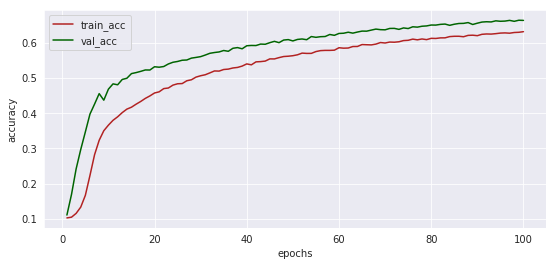

In [101]:
acc = results.history['acc']
val_acc = results.history['val_acc']
x = range(1, len(acc)+1)

plt.figure(figsize=(9,4))
sns.set_style('darkgrid')
sns.lineplot(x, y= acc, c="firebrick", \
             legend='brief', label="train_acc")
sns.lineplot(x, y=val_acc, c="darkgreen", \
             legend='brief', label="val_acc")
plt.legend(loc=0)
plt.xlabel('epochs')
plt.ylabel('accuracy')

Text(0.5, 1.0, 'Pérdida en entrenamiento y validación')

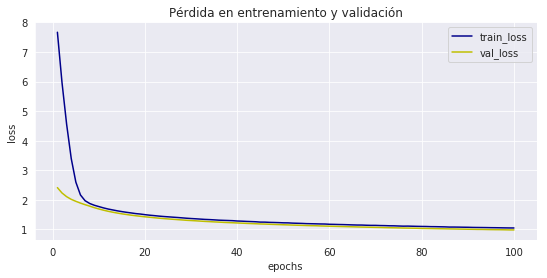

In [102]:
loss = results.history['loss']
val_loss = results.history['val_loss']
x = range(1, len(acc)+1)

plt.figure(figsize=(9,4))
sns.set_style('darkgrid')
sns.lineplot(x, y=loss, c="darkblue", \
             legend='brief', label="train_loss")
sns.lineplot(x, y=val_loss, c="y", \
             legend='brief', label="val_loss")
plt.legend(loc=0)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title("Pérdida en entrenamiento y validación")

> **Rendimiento del modelo en el conjunto test**

---

In [103]:
test_loss, test_acc = model.evaluate(test_features_flat, y_test_one_hot)
print("Precisión final alcanzada por la red normalizada y tras aplicar la técnica de transfer learnning:", 
      round(100*test_acc, 2), "%")

10000/10000 [==============================] - 0s 42us/step
Precisión final alcanzada por la red normalizada y tras aplicar la técnica de transfer learnning: 65.53 %


---
* **Conclusiones**

Finalmente, podemos observar que la precisión obtenida en el conjunto test es de aproximadamente un 66.5%, lo que indica que no se alcanza una alta precisión, de hecho, es con este método con el que hemos obtenido peores resultados al clasificar las imágenes de nuestro conjunto de datos. Además, dado que el volumen de datos, así como la complejidad de nuestra red no es excesivamente grande, no sería necesario acudir a este tipo de metodologías.

De todos modos, es una buena forma de comprender el funcionamiento de la técnica ***transfer learning*** que, si bien la capacitación de una Red Neuronal Convolucional (CNN) desde cero es posible para proyectos pequeños, como es nuestro caso, la mayoría de las aplicaciones requieren la capacitación de CNN muy grandes y esto, requiere enormes cantidades de datos procesados y potencia computacional. Y a día de hoy, ambos no se encuentran tan fácilmente.

Por ello, entra en juego esta técnica  que posee ciertas ventajas y es que no hay necesidad de un conjunto de datos de entrenamiento extremadamente grande además de no requerir una alta potencia computacional, al estar trabajando con pesos pre-entrenados y solo tener que aprender los pesos de las últimas capas.

